## Requirements

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision.datasets import MNIST
from torchvision import datasets, transforms

from advertorch.attacks import GradientSignAttack as FGSM

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## MNIST Model

In [2]:
class MnistModel(nn.Module):
    def __init__(self):
        super(MnistModel, self).__init__()
        # mnist의 경우 28*28의 흑백이미지(input channel=1)이다.
        self.conv1 = nn.Conv2d(1, 32, kernel_size = 5, padding=2)
        # feature map의 크기는 14*14가 된다
        # 첫번재 convolution layer에서 나온 output channel이 32이므로 2번째 input도 32
        self.conv2 = nn.Conv2d(32, 64, kernel_size = 5, padding=2)
        # feature map의 크기는 7*7이 된다
        # fc -> fully connected, fc는 모든 weight를 고려해서 만들기 때문에 cnn에서는 locally connected를 이용하여 만든다.
        # nn.Linear에서는 conv를 거친 feature map을 1차원으로 전부 바꿔서 input을 한다. 이게 64*7*7
        self.fc1 = nn.Linear(64*7*7, 1024)
        self.fc2 = nn.Linear(1024, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, 64*7*7) # linear에 들어갈 수 있도록 reshape
        x = F.relu(self.fc1(x)) # fully connected에 relu 적용
        x = F.dropout(x, training=self.training) # 가중치 감소만으로는 overfit을 해결하기가 어려움, 그래서 뉴런의 연결을 임의로 삭제
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

## Load Dataset

In [3]:
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])),
        batch_size=1, shuffle=True)

mnist_transform = transforms.Compose([
    transforms.ToTensor(),
])

download_path = './data'
test_dataset = MNIST(download_path, transform=mnist_transform, train=False, download=True)

In [4]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')
print("CUDA Available:", is_cuda)

CUDA Available: True


## Attack Image

In [5]:
def fgsm_attack(model, device, test_loader):
    print("Attack Image!!")
    adversary = FGSM(model, loss_fn=nn.NLLLoss(reduction='sum'), 
                    eps=0.3, clip_min=0., clip_max=1., targeted=False)
    perturbed_images = []

    for image, label in test_loader:
        image, label = image.to(device), label.to(device)
        perturbed_images.append((adversary.perturb(image, label), label))

    print("Attack Done!!")
    return perturbed_images

In [6]:
# UM
UM_model_path = './model/mnist_um.pth'
UM_model = MnistModel().to(device)
UM_model.load_state_dict(torch.load(UM_model_path, map_location=device))

perturbed_images = fgsm_attack(UM_model, device, test_loader)

Attack Image!!
Attack Done!!


## Test Models

In [7]:
def test(model, device, images):
    # Accuracy counter
    correct = 0
    failed_examples = []
    correct_examples = []

    # test set의 모든 예제를 test한다
    for image, label in images:
        # cpu나 gpu로 데이터를 전송한다
        image, label = image.to(device), label.to(device)

        # Re-classify the perturbed image
        output = model(image)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == label.item():
            correct += 1
            if (len(correct_examples) < 5):
                adv_ex = image.squeeze().detach().cpu().numpy()
                correct_examples.append( (label.item(), final_pred.item(), adv_ex) )
        else:
            if len(failed_examples) < 5:
                adv_ex = image.squeeze().detach().cpu().numpy()
                failed_examples.append( (label.item(), final_pred.item(), adv_ex) )

    # final_acc = correct/idx
    final_acc = correct/float(len(images))
    print("Test Accuracy = {} / {} = {}".format(correct, len(images), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, correct_examples, failed_examples

### Undefined Model

In [8]:
normal_accuracies = []

print('Normal:')
acc, UM_correct, UM_failed = test(UM_model, device, perturbed_images)
normal_accuracies.append(acc)

Normal:
Test Accuracy = 2061 / 10000 = 0.2061


### FGSM Model

In [9]:
# FGSM
Linf_model1_path = './model/mnist_fgsm_model.pth'
Linf_model1 = MnistModel().to(device)
Linf_model1.load_state_dict(torch.load(Linf_model1_path, map_location=device))

Linf_1_accuracies = []

print('FGSM(Linf) Trained:')
acc, Linf1_correct, Linf1_failed = test(Linf_model1, device, perturbed_images)
Linf_1_accuracies.append(acc)

FGSM(Linf) Trained:
Test Accuracy = 6619 / 10000 = 0.6619


### PGD Model

In [10]:
# PGD
Linf_model2_path = './model/mnist_pgd_model.pth'
Linf_model2 = MnistModel().to(device)
Linf_model2.load_state_dict(torch.load(Linf_model2_path, map_location=device))

Linf_2_accuracies = []

print('PGD(Linf) Trained:')
acc, Linf2_correct, Linf2_failed = test(Linf_model2, device, perturbed_images)
Linf_2_accuracies.append(acc)

PGD(Linf) Trained:
Test Accuracy = 9368 / 10000 = 0.9368


### Deepfool Model

In [11]:
# Deepfool
L2_model_path = './model/mnist_deepfool_model.pth'
L2_model = MnistModel().to(device)
L2_model.load_state_dict(torch.load(L2_model_path, map_location=device))

L2_accuracies = []

print('Deepfool(L2) defense:')    
acc, L2_correct, L2_failed = test(L2_model, device, perturbed_images)
L2_accuracies.append(acc)

Deepfool(L2) defense:
Test Accuracy = 5610 / 10000 = 0.561


### JSMA Model

In [12]:
# JSMA
L0_model_path = './model/mnist_jsma_model.pth'
L0_model = MnistModel().to(device)
L0_model.load_state_dict(torch.load(L0_model_path, map_location=device))

L0_accuracies = []

print('JSMA(L0) defense:')    
acc, L0_correct, L0_failed = test(L0_model, device, perturbed_images)
L0_accuracies.append(acc)

JSMA(L0) defense:
Test Accuracy = 3105 / 10000 = 0.3105


# Results

### Accuracy

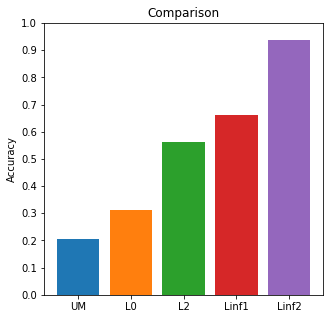

In [13]:
plt.figure(figsize=(5,5))
plt.bar(['UM'], normal_accuracies, label='UM')
plt.bar(['L0'], L0_accuracies, label='L0')
plt.bar(['L2'], L2_accuracies, label='L2')
plt.bar(['Linf1'], Linf_1_accuracies, label='Linf1')
plt.bar(['Linf2'], Linf_2_accuracies, label='Linf2')
plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.title("Comparison")
plt.ylabel("Accuracy")
plt.show()

### Correct Images

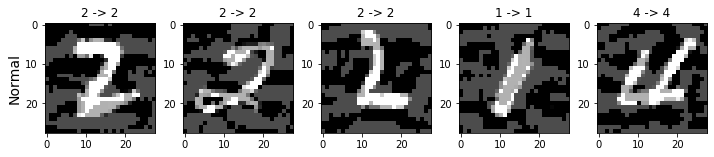

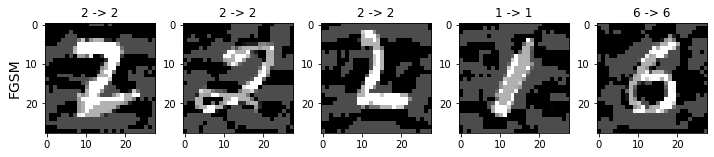

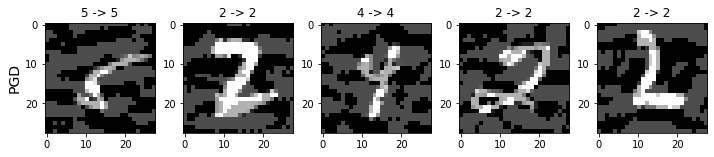

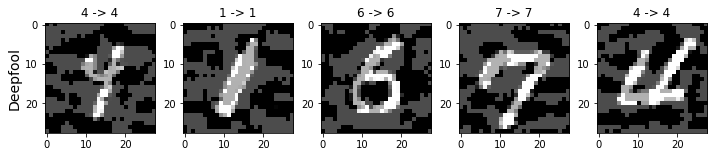

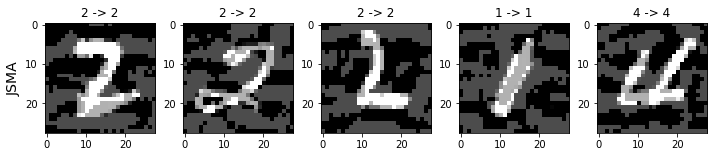

In [14]:
plt.figure(figsize=(10,10))

cnt = 0
for i in range(len(UM_correct)):
    cnt += 1
    plt.subplot(5, len(UM_correct), cnt)
    if i == 0:
        plt.ylabel("Normal", fontsize=14)
    orig,adv,ex = UM_correct[i]
    plt.title("{} -> {}".format(orig, adv))
    plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,10))
cnt = 0
for i in range(len(Linf1_correct)):
    cnt += 1
    plt.subplot(5, len(Linf1_correct), cnt)
    if i == 0:
        plt.ylabel("FGSM", fontsize=14)
    orig,adv,ex = Linf1_correct[i]
    plt.title("{} -> {}".format(orig, adv))
    plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,10))    
cnt = 0
for i in range(len(Linf2_correct)):
    cnt += 1
    plt.subplot(5, len(Linf2_correct), cnt)
    if i == 0:
        plt.ylabel("PGD", fontsize=14)
    orig,adv,ex = Linf2_correct[i]
    plt.title("{} -> {}".format(orig, adv))
    plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,10))    
cnt = 0
for i in range(len(L2_correct)):
    cnt += 1
    plt.subplot(5, len(L2_correct), cnt)
    if i == 0:
        plt.ylabel("Deepfool", fontsize=14)
    orig,adv,ex = L2_correct[i]
    plt.title("{} -> {}".format(orig, adv))
    plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()
    
plt.figure(figsize=(10,10))   
cnt = 0
for i in range(len(L0_correct)):
    cnt += 1
    plt.subplot(5, len(L0_correct), cnt)
    if i == 0:
        plt.ylabel("JSMA", fontsize=14)
    orig,adv,ex = L0_correct[i]
    plt.title("{} -> {}".format(orig, adv))
    plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

### Failed Image

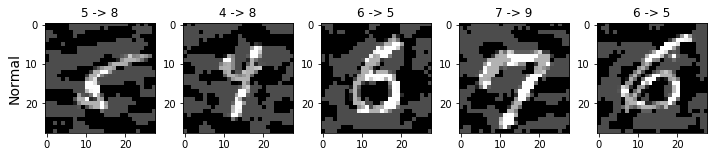

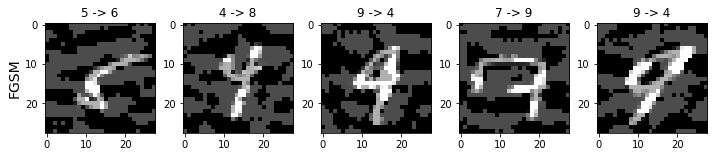

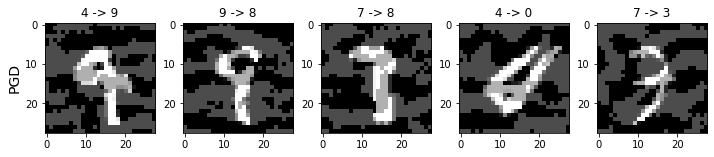

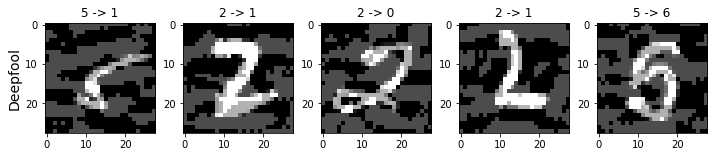

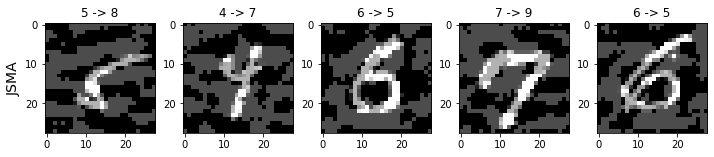

In [15]:
plt.figure(figsize=(10,10))

cnt = 0
for i in range(len(UM_failed)):
    cnt += 1
    plt.subplot(5, len(UM_failed), cnt)
    if i == 0:
        plt.ylabel("Normal", fontsize=14)
    orig,adv,ex = UM_failed[i]
    plt.title("{} -> {}".format(orig, adv))
    plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,10))
cnt = 0
for i in range(len(Linf1_failed)):
    cnt += 1
    plt.subplot(5, len(Linf1_failed), cnt)
    if i == 0:
        plt.ylabel("FGSM", fontsize=14)
    orig,adv,ex = Linf1_failed[i]
    plt.title("{} -> {}".format(orig, adv))
    plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,10))    
cnt = 0
for i in range(len(Linf2_failed)):
    cnt += 1
    plt.subplot(5, len(Linf2_failed), cnt)
    if i == 0:
        plt.ylabel("PGD", fontsize=14)
    orig,adv,ex = Linf2_failed[i]
    plt.title("{} -> {}".format(orig, adv))
    plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,10))    
cnt = 0
for i in range(len(L2_failed)):
    cnt += 1
    plt.subplot(5, len(L2_failed), cnt)
    if i == 0:
        plt.ylabel("Deepfool", fontsize=14)
    orig,adv,ex = L2_failed[i]
    plt.title("{} -> {}".format(orig, adv))
    plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()
    
plt.figure(figsize=(10,10))   
cnt = 0
for i in range(len(L0_failed)):
    cnt += 1
    plt.subplot(5, len(L0_failed), cnt)
    if i == 0:
        plt.ylabel("JSMA", fontsize=14)
    orig,adv,ex = L0_failed[i]
    plt.title("{} -> {}".format(orig, adv))
    plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()